In [1]:
# add all libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
plt.style.use('ggplot')

In [2]:
# get basic informations
df = pd.read_csv('recipe_site_traffic_2212.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


In [3]:
# check unique values of each column
for col in df.columns:
    print(f'Num of unique values of {col}: {df[col].nunique()}')

Num of unique values of recipe: 947
Num of unique values of calories: 891
Num of unique values of carbohydrate: 835
Num of unique values of sugar: 666
Num of unique values of protein: 772
Num of unique values of category: 11
Num of unique values of servings: 6
Num of unique values of high_traffic: 1


In [4]:
# check if calories, carbohydrate, sugar, protein have missing values in the same recipe
recipe_calories = df[df['calories'].isna()]['recipe']
recipe_carbohydrate = df[df['carbohydrate'].isna()]['recipe']
recipe_sugar = df[df['sugar'].isna()]['recipe']
recipe_protein = df[df['protein'].isna()]['recipe']
if recipe_calories.equals(recipe_carbohydrate) & recipe_calories.equals(recipe_sugar) & recipe_calories.equals(recipe_protein):
    print('calories, carbohydrate, sugar, protein have missing values in the same recipe.')
else:
    print('calories, carbohydrate, sugar, protein do NOT have missing values in the same recipe.')

calories, carbohydrate, sugar, protein have missing values in the same recipe.


In [5]:
# fill missing values with mean values for calories, carbohydrate, sugar, protein according to category of the recipe
miss_list = ['calories', 'carbohydrate', 'sugar', 'protein']
for miss in miss_list:
    df[miss] = df.groupby('category')[miss].apply(lambda x: x.fillna(round(x.mean(), 2)))

In [6]:
# convert High to 1 and missing value to 0
df['high_traffic'] = df['high_traffic'].replace({'High':1})
df['high_traffic'] = df['high_traffic'].fillna(0).astype(int)


In [7]:
# check basic information again after changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      947 non-null    float64
 2   carbohydrate  947 non-null    float64
 3   sugar         947 non-null    float64
 4   protein       947 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  947 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 59.3+ KB


## Exploratory Analysis

I have investigated the target variable(high_traffic) and features(calories, carbohydrate, sugar, protein, category, servings), and the relationship between target variable and features.

### Target Variable - high_traffic

Since we need to predict the traffic of site: high (converted already to 1) or not high (converted already to 0), the high_traffic variable would be our target variable. From the **Graph 1**, we can see the distribution of target variable is mild balanced: high: not high is 6:4. Therefore, we do not need to balance dataset.

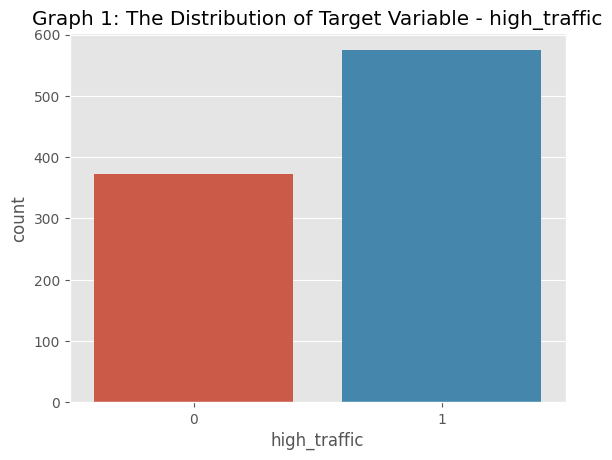

Distribution of high_traffic: 
 1    0.606125
0    0.393875
Name: high_traffic, dtype: float64


In [8]:
sns.countplot(x=df['high_traffic']).set(title='Graph 1: The Distribution of Target Variable - high_traffic')
plt.show()
print('Distribution of high_traffic: \n', df['high_traffic'].value_counts(normalize=True))

### Two Categorical Variable - category and servings

From **Graph 2**, we can see all categories in category variable has the almost same frequency. 

From **Graph 3**, we can see the least frequent categories in servings variable: 4 as a snack and 6 as a snack.

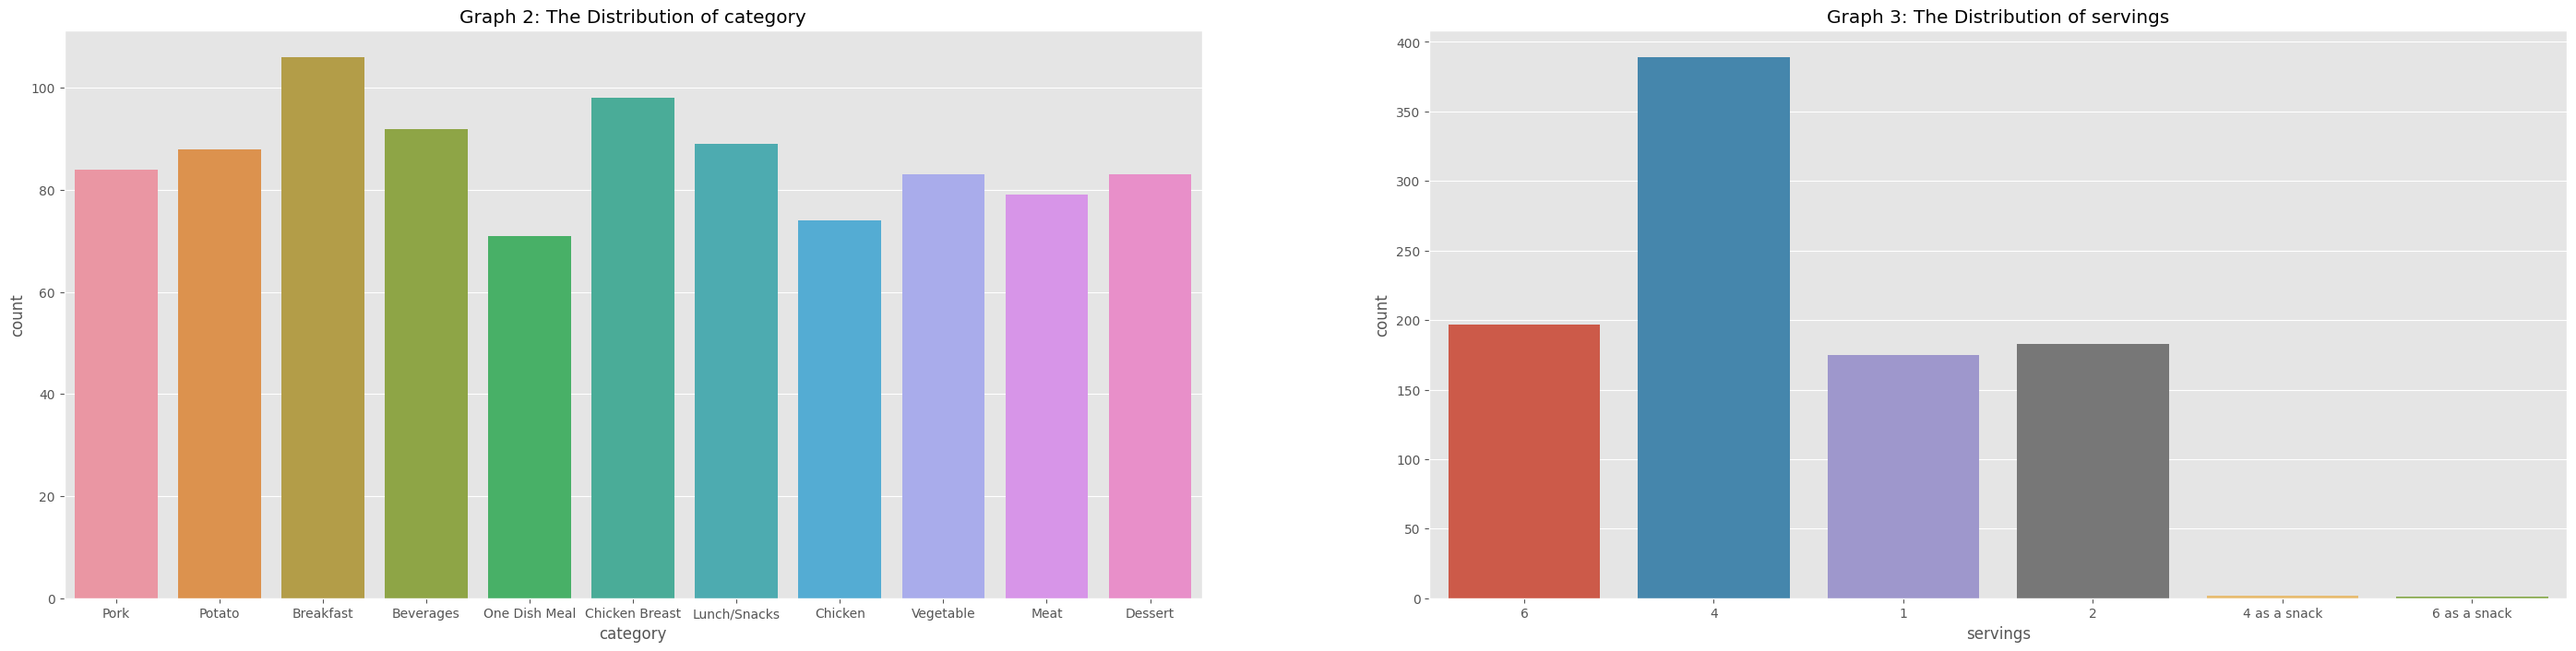

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(35,8))
sns.countplot(x=df['category'], ax=axes[0]).set(title='Graph 2: The Distribution of category')
sns.countplot(x=df['servings'], ax=axes[1]).set(title='Graph 3: The Distribution of servings')
plt.show()

### Numerical Variables - calories, carbohydrate, sugar, protein

From **Graph 4** below, we could conclude that there is no linear relationship between calories, carbohydrate, sugar, protein.

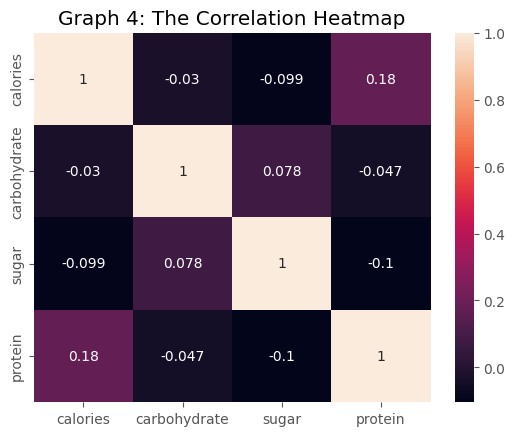

In [10]:
sns.heatmap(df[['calories', 'carbohydrate', 'sugar', 'protein']].corr(),annot=True).set(title='Graph 4: The Correlation Heatmap')
plt.show()

#### Relationship between calories, carbohydrate, sugar, protein and high_traffic

From **Graph 5 to Graph 8**, we can see calories, carbohydrate, sugar, protein might be the good indicators for prediction, because in violinplots the distribustions of them for differen high_traffic are different.

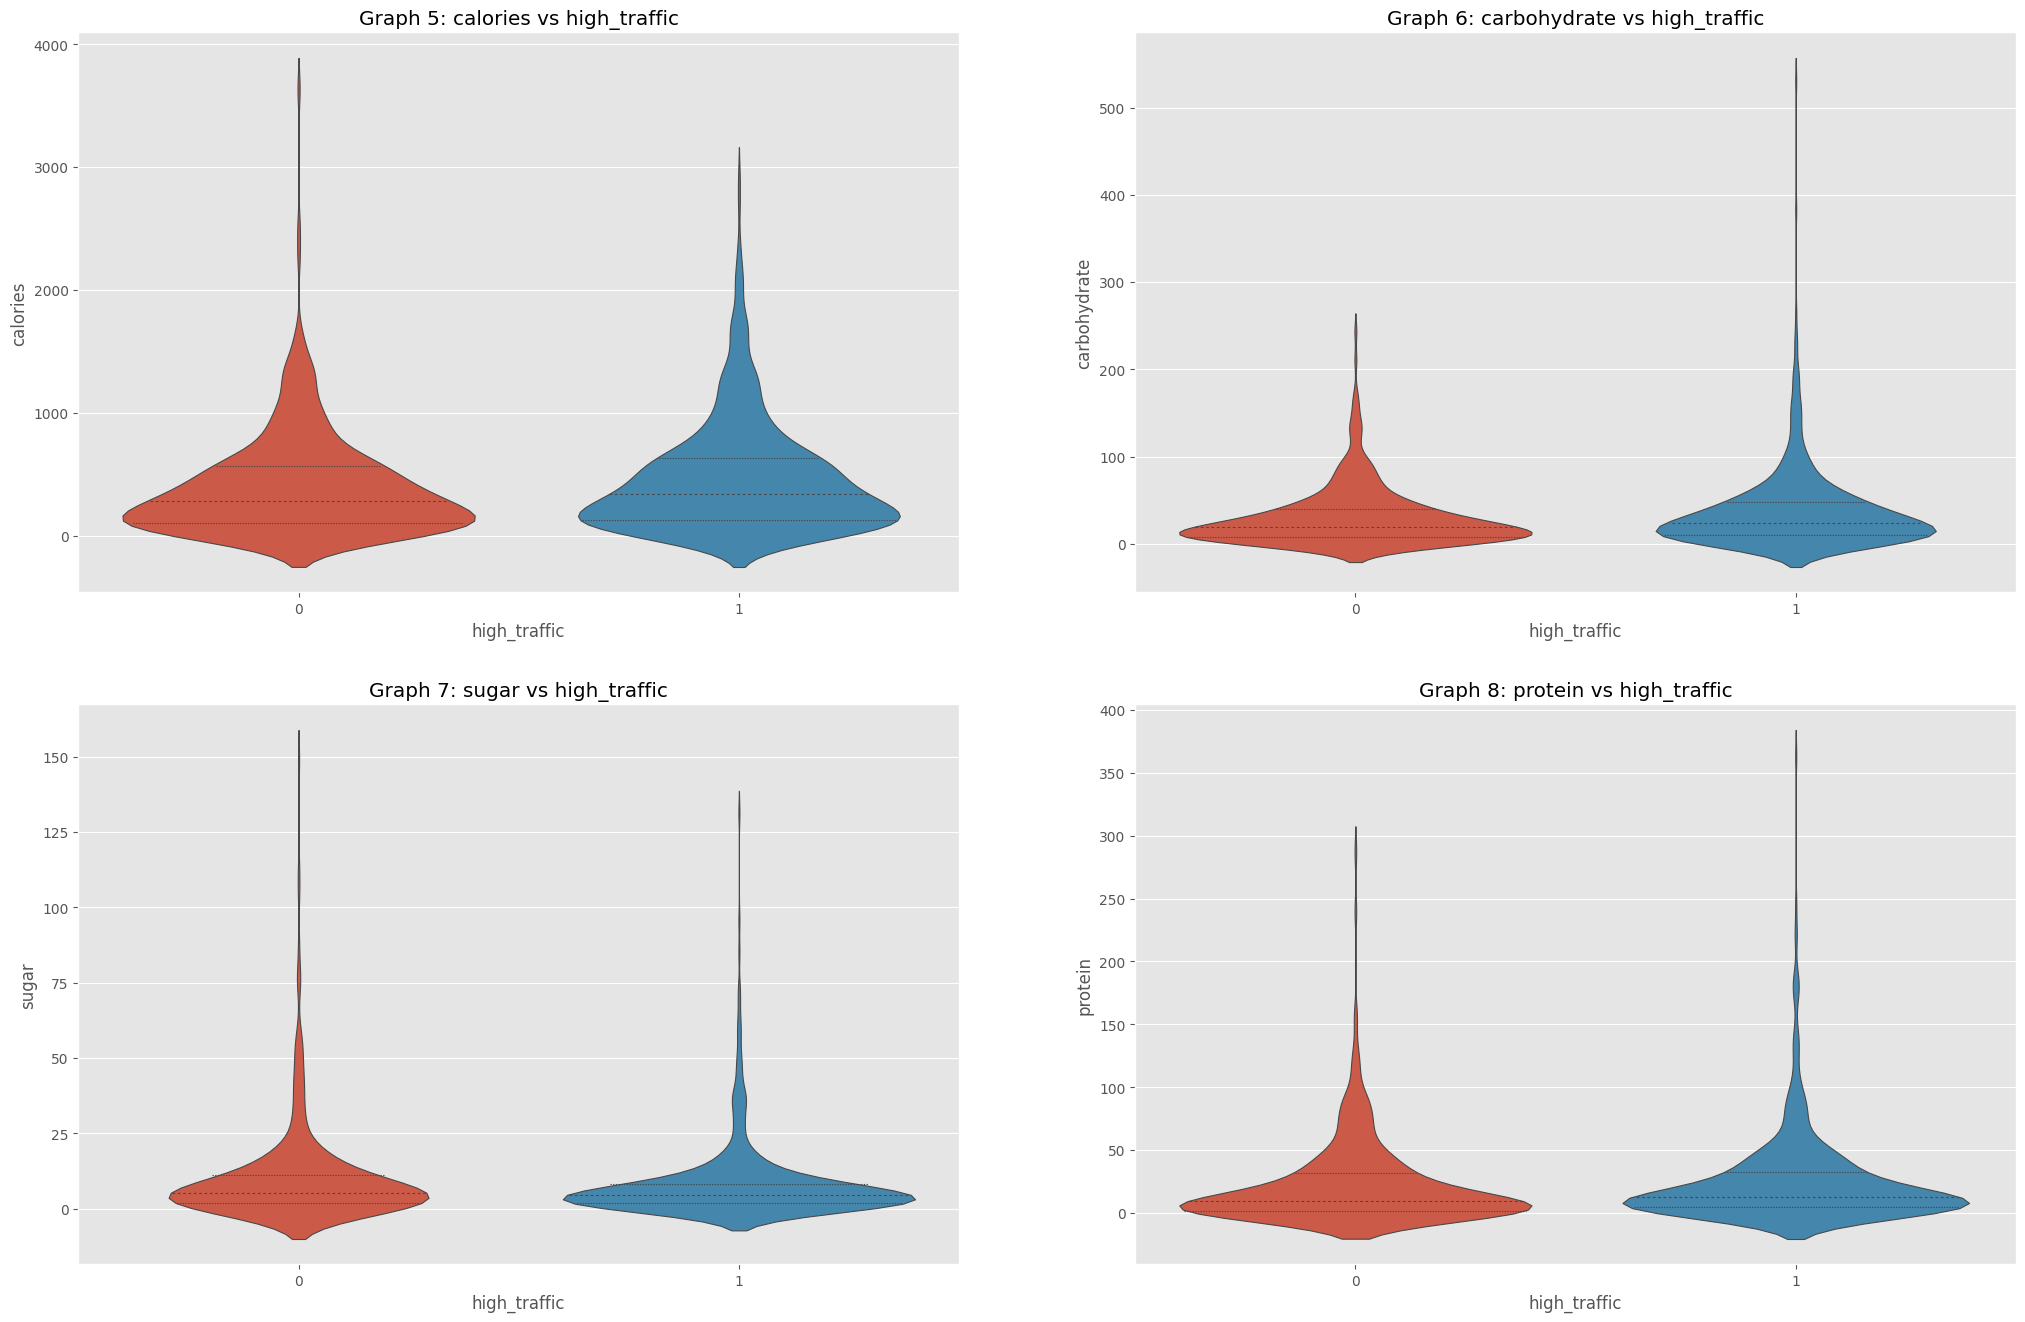

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(25,16))
sns.violinplot(data=df, x='high_traffic', y='calories', linewidth=0.8, inner='quartile', ax=axes[0,0]).set(title='Graph 5: calories vs high_traffic')
sns.violinplot(data=df, x='high_traffic', y='carbohydrate', linewidth=0.8, inner='quartile', ax=axes[0,1]).set(title='Graph 6: carbohydrate vs high_traffic')
sns.violinplot(data=df, x='high_traffic', y='sugar', linewidth=0.8, inner='quartile', ax=axes[1,0]).set(title='Graph 7: sugar vs high_traffic')
sns.violinplot(data=df, x='high_traffic', y='protein', linewidth=0.8, inner='quartile', ax=axes[1,1]).set(title='Graph 8: protein vs high_traffic')
plt.show()

## Model Development and Model Evaluation

Predicting the traffic of site is a **binary classification problem**. 

I am choosing the **Logistic Regression Model** as a baseline model because it is very efficient to train and interpret.

The comparison model I am choosing is the **Decision Tree model** because it can handle both numerical and categorical data and nonlinear relationships between variables do not affect tree performance.

For evaluation, the **accuracy** is used, because the goal is that correctly predicting high traffic.

The accuracy of the Logistic Regression is **82.1%** and the best accuracy of the Decision Tree model is **80.5%** with max_depth=3. The results mean the Logistic Regression model fits the features better.

### Prepare Data for Modelling
To enable modelling, i chose category, servings, calories, carbohydrate, sugar, protein as features, high_traffic as target variables. The following are changes/notes:
- recipe is not used, because it is only the unique identifier of recipe.
- Normalize the numeric features
- Convert the categorical variables into numeric features.
- Split the data into a training-dataset and a validate-dataset (8:2)

In [12]:
# make dataset for training
feature = ['category', 'servings', 'calories', 'carbohydrate', 'sugar', 'protein']
X = df[feature] # Features
y = df['high_traffic'] # Target variable

# normalize dataset
scaler = Normalizer()
scaler.fit(X[['calories', 'carbohydrate', 'sugar', 'protein']])
X[['calories', 'carbohydrate', 'sugar', 'protein']] = scaler.transform(X[['calories', 'carbohydrate', 'sugar', 'protein']])

# convert the categorical variables into numeric features with dummy encoding
label_encoder_category = LabelEncoder()
label_encoder_servings = LabelEncoder()
label_encoder_category.fit(X['category'])
label_encoder_servings.fit(X['servings'])
X['category'] = label_encoder_category.transform(X['category'])
X['servings'] = label_encoder_servings.transform(X['servings'])

# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=515)

### Baseline: Logistic Regression Model

In [13]:
log_reg = LogisticRegression(random_state=515)
log_reg.fit(X_train,y_train)
y_pred_log_reg = log_reg.predict(X_test)
print('Accuracy of the Logistic Regression Model: ',accuracy_score(y_test, y_pred_log_reg))

Accuracy of the Logistic Regression Model:  0.8210526315789474


### Comparison Model: Decision Tree Model

In [14]:
# Create Decision Tree classifer object
depth_list = [i+1 for i in range(50)]
tree_models = []
tree_acc_list = {}
for depth in depth_list:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=515)
    tree = tree.fit(X_train,y_train)
    tree_models.append(tree)
    y_pred_tree = tree.predict(X_test)
    tree_acc_list[depth] = accuracy_score(y_test, y_pred_tree)
    
print(f'Best accuracy of the Decision Tree Model: {tree_acc_list[max(tree_acc_list, key=tree_acc_list.get)]} in depth {max(tree_acc_list, key=tree_acc_list.get)}')

Best accuracy of the Decision Tree Model: 0.8052631578947368 in depth 3


## Business Metrics

To find definition of a metric for the business to monitor. I firstly ploted the imprtance of features in both the logistic regression model and the tree decision model. The results are **Graph 9** and **Graph 10**. From them, we can see the most important feature is **category** variable. So the idea is according to category to define the business metrics.

From **Graph 11**, we can see the ratio of high traffic (1) and not high traffic (0) in some categories are over 80%. 80% is the goal. But in order to maximize the possibility of showing popular recipes, i chossed the categories which has ratio is over 70% instead of 80%. And they are: **Vegetable, Potato, Pork, One Dish Meal, Meat**.

So I choosed the **qualitative KPI** in this case. The definition of the KPI in this case is: 
- most likely will be popular: if the recipe is belongs to **Vegetable, Potato, Pork, One Dish Meal, Meat**
- most likely will be unpopular: if the recipe is belongs to **Beverages, Breakfast, Chicken, Chicken Breast, Dessert, Lunch/Snacks**

As the results of predicting the new dataset using the defined KPI, both models perfomence same. The accuracy is 87.2%. It is over the goal(80%).

### Feature Importance

To find the important features in the logistic regression model and the tree decision model.

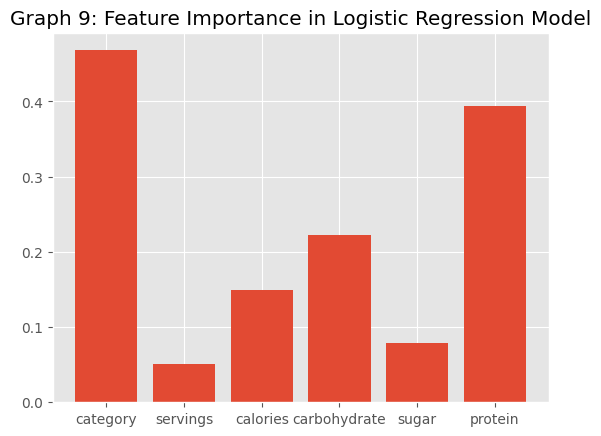

In [15]:
# get the feature importance in logistic regression model
log_reg_importance = log_reg.coef_[0]
resultdict = {}
for i in range(len(log_reg.feature_names_in_)):
    resultdict[log_reg.feature_names_in_[i]] = log_reg_importance[i]
    
plt.bar(resultdict.keys(),resultdict.values())

plt.title('Graph 9: Feature Importance in Logistic Regression Model');
plt.show()

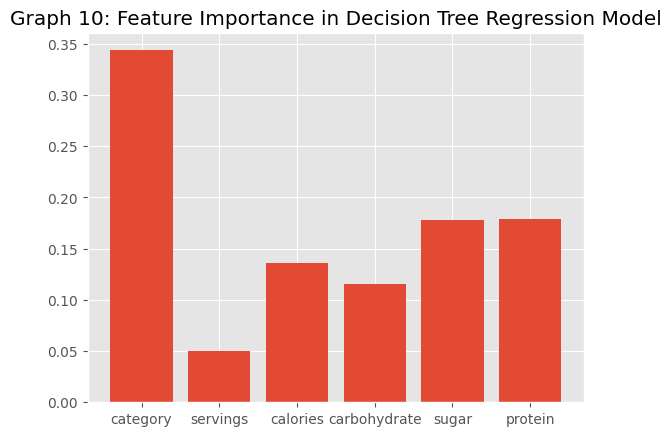

In [16]:
# get the feature importance in decesion tree model
tree_importance = {}
for i in range(len(tree.feature_names_in_)):
    tree_importance[tree.feature_names_in_[i]] = tree.feature_importances_[i]
        
plt.bar(tree_importance.keys(),tree_importance.values())
plt.title('Graph 10: Feature Importance in Decision Tree Regression Model')
plt.show()

### Important Categories

We can get the categories which should be monitored.

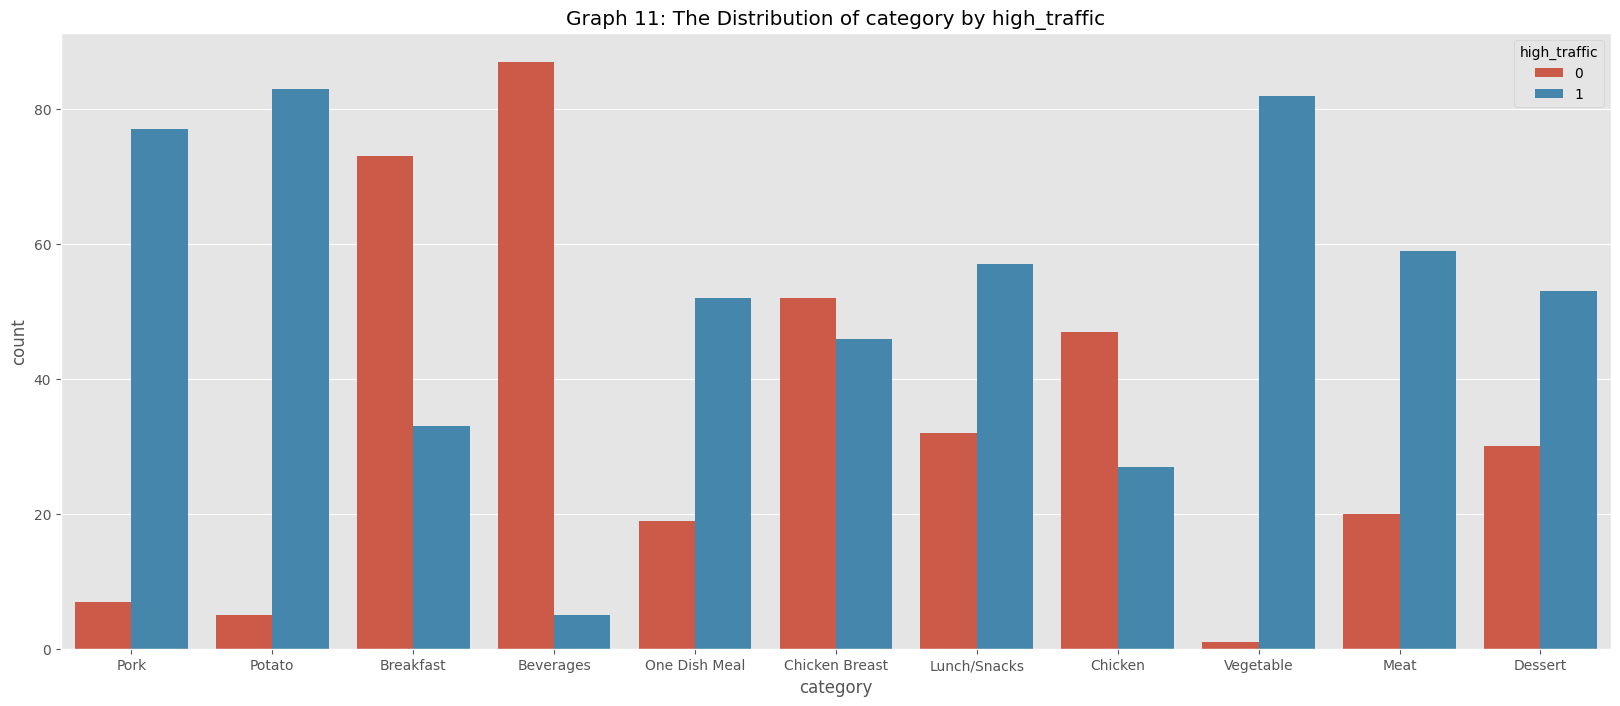

category        high_traffic
Beverages       0               0.945652
                1               0.054348
Breakfast       0               0.688679
                1               0.311321
Chicken         0               0.635135
                1               0.364865
Chicken Breast  0               0.530612
                1               0.469388
Dessert         1               0.638554
                0               0.361446
Lunch/Snacks    1               0.640449
                0               0.359551
Meat            1               0.746835
                0               0.253165
One Dish Meal   1               0.732394
                0               0.267606
Pork            1               0.916667
                0               0.083333
Potato          1               0.943182
                0               0.056818
Vegetable       1               0.987952
                0               0.012048
Name: high_traffic, dtype: float64


In [17]:
# plot caterories by high_traffic
plt.figure(figsize=(20, 8))
sns.countplot(x=df['category'], hue=df['high_traffic']).set(title='Graph 11: The Distribution of category by high_traffic')
plt.show()
print(df.groupby('category')['high_traffic'].value_counts(normalize=True))

### Comparing Models using the defined KPI

The new dataset has only the most likely will be popular recipes. That means the recipe can only be one of Vegetable, Potato, Pork, One Dish Meal, Meat.

Logistic regression model and decesion tree model predict the new dataset to check if the goal is achieved.

In [18]:
# get the new dataset with monitored categories
df_business = df[(df['category']=='Pork') | (df['category']=='Potato') | (df['category']=='One Dish Meal') |\
                (df['category']=='Vegetable') | (df['category']=='Meat') ]

# prepare the new dataset for predicting
X_business = df_business[feature]
y_business = df_business['high_traffic'] 
X_business[['calories', 'carbohydrate', 'sugar', 'protein']] = scaler.transform(X_business[['calories', 'carbohydrate', 'sugar', 'protein']])
X_business['category'] = label_encoder_category.transform(X_business['category'])
X_business['servings'] = label_encoder_servings.transform(X_business['servings'])

In [19]:
# use logistic regression model to predict the new dataset
y_pred_log_reg_business = log_reg.predict(X_business)
print('Accuracy with specific data and logistic regression model: ', accuracy_score(y_business, y_pred_log_reg_business))

Accuracy with specific data and logistic regression model:  0.8716049382716049


In [20]:
# use decesion tree model to predict the new dataset
y_pred_tree_business = tree_models[2].predict(X_business)
print('Accuracy with specific data and decision tree model: ', accuracy_score(y_business, y_pred_tree_business))

Accuracy with specific data and decision tree model:  0.8716049382716049


## Summary

To help Tasty Bytes better predict the recipe which will be popular, we can do the first filter: choose recipe belongs to Vegetable, Potato, Pork, One Dish Meal, Meat. And we can deploy **Logistic Regression Model** and **Decision Tree Model** into production to calculate accuracy. If accuracies from both both models are over 80%, we could choose this recipe.

To better evaluate whether modles can really help company, I would also recommend A/B testing about using models to compare two groups of recipes. 

To implement and improve the model, I will consider the following steps:

- Collecting more data, e.g.Fat, time to cook and cost.

- Feature Engineering, e.g  reduce the categories in model, create more meaningful features from the variables.